## Общее описание:

 В данном эксперименте мы проверяем, действительно ли качество сервиса
<br>
(приложение онлайн-знакомтсв) улучшится в случае  внедрения нового алгоритма поиска пар.

Чтобы это проверить, решено разделить всех пользователей на две группы.
    <br>
    Пользователи в группе с номером 0 пользовались приложением со старым алгоритмом. 

Все пользователи в группе 1 пользовались приложением с новым алгоритмом для поиска анкет.

 

## Описание данных

- `user_id_1`,`user_id_2` - id пользователя из пары
- `group` - экспериментальная группа
- `is_match` - случился ли матч в паре



### План

**1. Планирование эксперимента: выбираем метрики, формулируем гипотезы эксперимента** 

**2. Подготовка к работе. Импорт необходимых библиотек и загрузка данных**
   
**3. Изучение данных. Визуализация кол-ва мэтчей в обеих группах и подсчет долей мэтчей в процентном соотношении**

**4. Выбор и проведение теста. Формулирование выводов**




<hr style="border:1px solid">

## 1. Планирование эксперимента: выбираем метрики, формулируем гипотезы эксперимента

<u>Нулевая гипотеза эксперимента</u> - новый алгоритм существенно не повлиял на долю мэтчей в общих действиях
<br>
    пользователей по поиску пары.
<br><br>
 <u>Альтернативная гипотеза эксперимента</u> - новый алгоритм поспособствовал увеличению доли мэтчей.


Целевой метрикой, по которой будем судить об успешности нового алгоритма, будем считать соотношение кол-ва мэтчей к общему кол-ву действий по поиску пары.
    
MDE для такой метрики - это возможность засечь как минимум 10% увеличение доли мэтчей

 Таким образом, эксперимент будет удачен, т.е. будет подтверждено наличие минимального эффекта в случае стат. значимого увеличения 
<br>
    доли мэтчей в процессе поиска пары в тестовой группе как минимум на 10%.

<hr style="border:1px solid">

## 2. Подготовка к работе. Импорт необходимых библиотек и загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import pingouin as pg
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
# Устанавливаем общие настройки для графиков

sns.set(
rc={
    'figure.figsize':(46,15)
},
font_scale=2
)

In [3]:
# Загружаем данные

df = pd.read_csv('../dating_data.csv')

In [4]:
# Смотрим на данные 

df.head()

,user_id_1,user_id_2,group,is_match
0,79,91,1,1
1,716,353,1,1
2,423,677,0,0
3,658,165,1,1
4,969,155,0,1


<hr style="border:1px solid">

## 3. Изучаем данные

### 3.1. Проверяем данные на наличие пропущенных значений, строк-дубликатов, смотрим размер данных

In [24]:
# Смотрим на размер данных

df.shape

(14514, 4)

In [6]:
# Смотрим на типы данных

df.dtypes

user_id_1    int64
user_id_2    int64
group        int64
is_match     int64
dtype: object

In [7]:
# Проверяем данные на наличие дупликатов

df.loc[df.duplicated()]

,user_id_1,user_id_2,group,is_match


In [8]:
# Проверяем данные на наличие пустых значений

df.isna().sum()

user_id_1    0
user_id_2    0
group        0
is_match     0
dtype: int64

In [9]:
# Смотрим, насколько равномерно распределны юзеры по полу (user_id_1, user_id_2) в каждой из групп

df_grouped_users = df.groupby('group', as_index=False).agg({'user_id_1':'nunique','user_id_2':'nunique'})

In [10]:
df_grouped_users

,group,user_id_1,user_id_2
0,0,501,501
1,1,499,499


<b>Видим, что юзеров каждого из полов в двух группах распределено равное количество, что дает нам право удостовериться, что группы однородны</b>

In [25]:
# Считаем размеры выборок в каждой из групп

df_grouped_users['total_users'] = df_grouped_users.user_id_1 + df_grouped_users.user_id_2

In [26]:
# В контрольной группе - 1002 пользователя.
# В тестовой - 998 пользователей.

df_grouped_users

,group,user_id_1,user_id_2,total_users
0,0,501,501,1002
1,1,499,499,998


### 3.2. Визуализируем данные

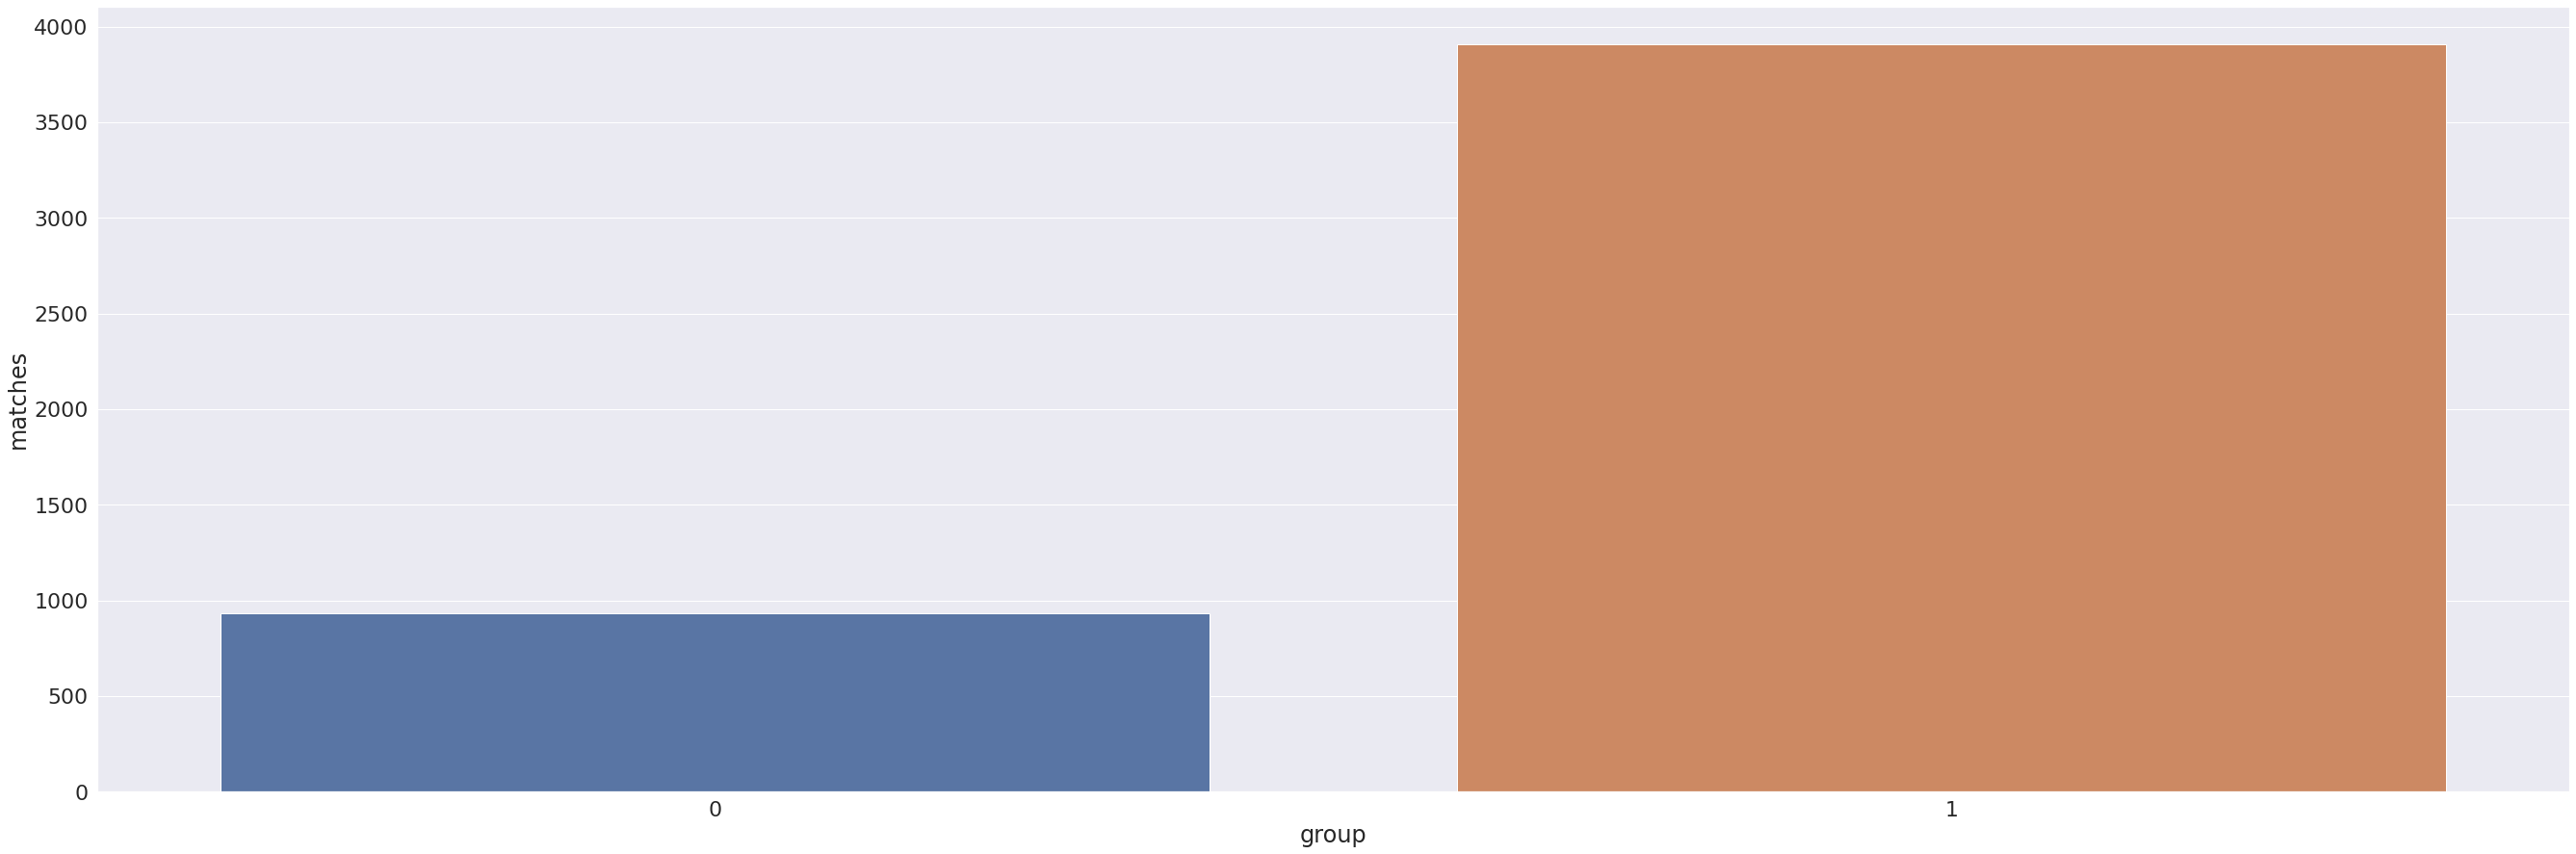

In [12]:
# Строим count plot кол-ва мэтчей в двух группах

matches_in_groups = df[['group','is_match']].query('is_match == 1')


sns.countplot(data=matches_in_groups, x='group')
plt.ylabel('matches')
plt.show()



<b>Видим, что в абсолютном отношении кол-во мэтчей в тестовой группе выше почти в 4 раза, чем в контрольной.
<br><br>
Несмотря на превышение мэтчей в тестовой группе над мэтчами в контрольной в абсолютных цифрах, 
<br>
необходимо посчитать общее количество мэтчей/немэтчей в каждой из групп, чтобы 
<br>
сравнить доли мэтчей в каждой из групп и в общем поиске пары в процентном соотношени,
<br>
и уже проводить тест на стат. значимость в разнице выявленных коэффициентов.
</b>

### 3.3. Подсчет долей мэтчей в обеих группах в процентном соотношении

In [13]:
# Для этого сначала строим таблицу сопряженности, чтобы выявить общее количество действий 
# в приложении в обоих группах.

crosstable_table = pd.crosstab(df.group, df.is_match, margins=True)



In [14]:
crosstable_table

is_match,0,1,All
group,,,
0,3858,934,4792
1,5813,3909,9722
All,9671,4843,14514


<b>Видим, что в контрольной группе меньше не только мэтчей, но и в целом остальных действий в приложении по поиску пары.
<br><br>
Поэтому теперь, чтобы точно понимать, что в тестовой группе доля мэтчей к любым действиям в приложении 
<br>
выше, чем в контрольной, считаем соответствующие доли мэтчей для обеих групп.</b>

In [15]:
share_of_matches_control = ((crosstable_table.iloc[(0,1)] / crosstable_table.loc[(0,'All')]) * 100).round(1)

In [16]:
share_of_matches_control

19.5

<b><u>19.5%</u> - доля мэтчей в действиях по поиску пары в контрольной группе</b>

In [17]:
share_of_matches_control = ((crosstable_table.iloc[(1,1)] / crosstable_table.loc[(1,'All')]) * 100).round(1)

In [18]:
share_of_matches_control

40.2

<b><u>40%</u> - доля мэтчей в действиях по поиску пары в тестовой группе</b>

<b>
Таким образом, предварительно выявлено, что процент мэтчей в тестовой группе
на 20% превышает процент мэтчей в контрольной. 

В рамках дальнейшего эксперимента необходимо будет проверить, является ли данная разница статистически значимой. 
</b>

<hr style="border:1px solid">

## 4. Выбираем тест и проводим тест. Формулируем выводы

In [19]:
# Для выбора правильного теста выводим таблицу сопряженноси

crosstable_table = crosstable_table.drop(columns='All', index='All')

In [20]:
crosstable_table

is_match,0,1
group,,
0,3858,934
1,5813,3909


<b>
Поскольку значения ожидаемых и наблюдаемых частот в каждой ячейке больше 10, 
<br>
выбираем критерий независимости Хи-квадрат Пирсона, который используется,чтобы определить,
<br>зависит ли распределение одной категориальной переменной от другой.
<br>

В данном случае у нас бинарная переменная (мэтч/немэтч, 1/0), которая может по-разному
<br>распределяться в тестовой и контрольной группах.

H0 : Новый алгоритм статистически не увеличивает долю мэтчей по сравнению с долей в контрольной группе, которая равна 19.5%.
<br><br>
H1 :  Новый алгоритм статистически увеличивает долю мэтчей в тестовой группе по сравнению с контрольной группой.


</b>



In [21]:
# Проводим тест, используя пакет scipy.stats

results = stats.chi2_contingency(crosstable_table)

In [23]:
results

(618.6889141576198,
 1.4418299163662586e-136,
 1,
 array([[3193.01584677, 1598.98415323],
        [6477.98415323, 3244.01584677]]))

In [22]:
print(f'p-значение - {results[1]}')

p-значение - 1.4418299163662586e-136


<b> Вывод: поскольку p-value по Пирсону оказался намного меньше 0.05, мы отвергаем H0 и делаем вывод о том, что наличествуют стат. различия в кол-вах мэтчей в контрольной и тестовой группах. 

 В данном случае мы получили стат. значимые различия в 20% между пропорциями мэтчей в контрольной и тестовой группах. Это больше, чем MDE (10%).

 Следовательно, поскольку кол-во мэтчей в тестовой группе (с новым алгоритмом) стат. значимо больше, делаем вывод: <u>можем выкатывать новый алгоритм подбора пар.</u></b> 